<a target="_blank" href="https://colab.research.google.com/github/shaankhosla/semanticsearch/blob/main/notebooks/HNSW_Hyperparam_Search.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [1]:
%%capture

%pip install hnswlib==0.8.0 matplotlib scikit-learn

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import hnswlib
import time

In [3]:
# Function to load the MNIST dataset
def load_mnist():
    # Load MNIST dataset
    mnist = fetch_openml("mnist_784")
    data = mnist.data.astype(np.float32)
    labels = mnist.target.astype(np.int)

    # Normalize data
    data /= 255.0
    return data, labels


# Load the dataset
data, labels = load_mnist()

# Displaying basic information about the dataset
print("MNIST dataset loaded")
print("Number of images:", data.shape[0])
print("Number of features per image:", data.shape[1])

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
<ipython-input-3-5d061e80b2cc>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = mnist.

MNIST dataset loaded
Number of images: 70000
Number of features per image: 784


In [4]:
data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


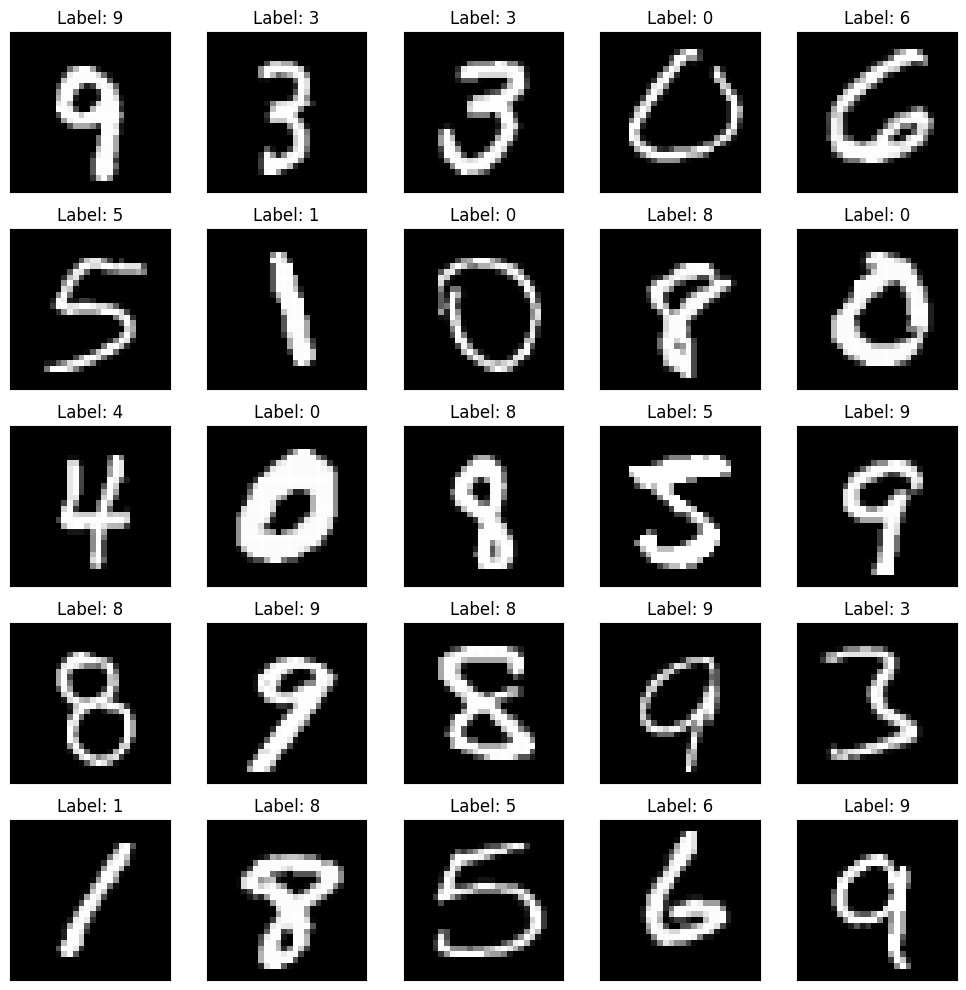

In [5]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

# Randomly select some images
indices = np.random.choice(range(len(data)), 25, replace=False)

for i, ax in enumerate(axes.flat):
    # Plot image
    image = data.iloc[indices[i]].to_numpy().reshape(28, 28)

    ax.imshow(image, cmap="gray")

    # Display the label
    ax.set_title(f"Label: {labels.iloc[indices[i]]}")

    # Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [6]:
def experiment_hyperparameters(data, M, efConstruction, query_data, query_labels, k=10):
    # Initialize the HNSW index
    index = hnswlib.Index(space="l2", dim=data.shape[1])
    index.init_index(max_elements=len(data), ef_construction=efConstruction, M=M)

    # Add data to the index
    index.add_items(data)

    # Set ef parameter for querying
    index.set_ef(efConstruction)  # this is different than ef_construction

    # Querying the index
    start_time = time.time()
    labels, _ = index.knn_query(query_data, k)
    query_time = time.time() - start_time

    # Calculate accuracy
    correct = 0
    for i, ids in enumerate(labels):
        # Check if the true label is in the set of retrieved labels from the training set
        predicted_ids = [train_labels[j] for j in ids]
        real_label = query_labels[i]

        if real_label in predicted_ids:
            correct += 1
    accuracy = correct / len(query_data)

    return accuracy, query_time

In [7]:
num_query = 1000  # Number of query points
train_data = data[:-num_query].to_numpy()
train_labels = labels[:-num_query].to_numpy()
query_data = data[-num_query:].to_numpy()
query_labels = labels[-num_query:].to_numpy()

# Hyperparameters to test
M_values = [2, 15]
efConstruction_values = [100, 300]

# Experiment and evaluate
results = []
for M in M_values:
    for efC in efConstruction_values:
        accuracy, query_time = experiment_hyperparameters(
            train_data, M, efC, query_data, query_labels
        )
        results.append((M, efC, accuracy, query_time))
        print(
            f"M: {M}, efConstruction: {efC}, Accuracy: {accuracy:.2f}, Query time: {query_time:.4f}s"
        )

M: 2, efConstruction: 100, Accuracy: 0.94, Query time: 0.1112s
M: 2, efConstruction: 300, Accuracy: 0.96, Query time: 0.2915s
M: 15, efConstruction: 100, Accuracy: 0.99, Query time: 0.3520s
M: 15, efConstruction: 300, Accuracy: 1.00, Query time: 0.8911s


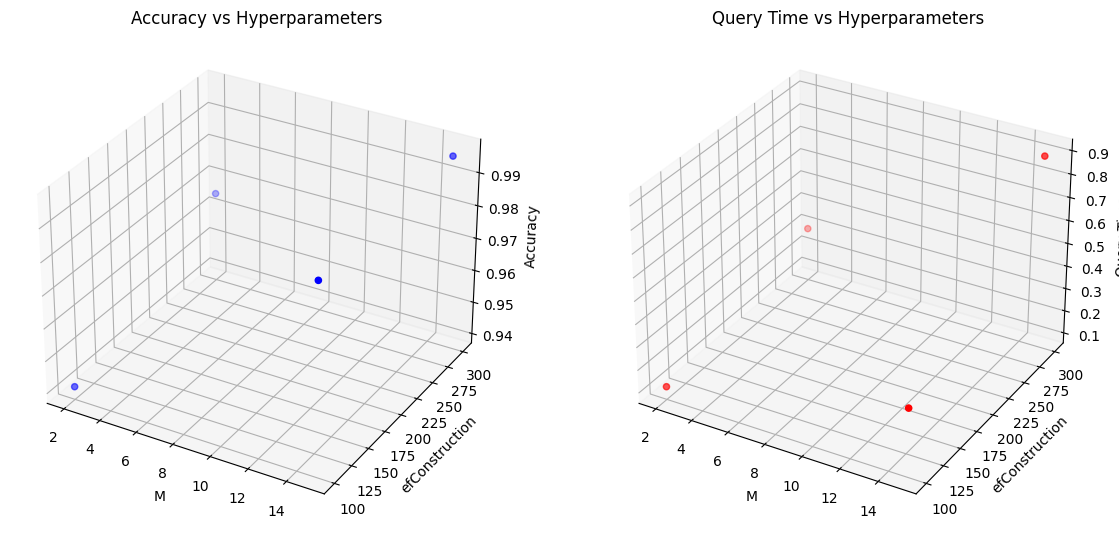

In [8]:
# Assuming 'results' is a list of tuples (M, efConstruction, accuracy, query_time)
M_values, efC_values, accuracies, query_times = zip(*results)

# 3D plot for Accuracy
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121, projection="3d")
ax.scatter(M_values, efC_values, accuracies, color="b")
ax.set_xlabel("M")
ax.set_ylabel("efConstruction")
ax.set_zlabel("Accuracy")
ax.set_title("Accuracy vs Hyperparameters")

# 3D plot for Query Time
ax2 = fig.add_subplot(122, projection="3d")
ax2.scatter(M_values, efC_values, query_times, color="r")
ax2.set_xlabel("M")
ax2.set_ylabel("efConstruction")
ax2.set_zlabel("Query Time")
ax2.set_title("Query Time vs Hyperparameters")

plt.show()